In [1]:
# Define the libraries
import numpy as np
import glob
import cv2
import pickle
import matplotlib.pyplot as plt

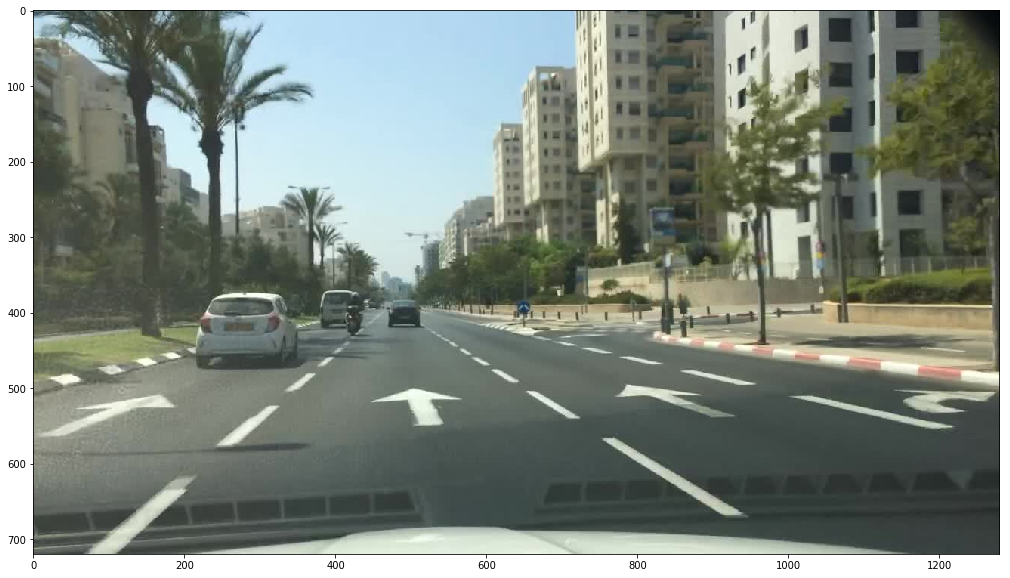

In [301]:
img = cv2.imread('./new_data/2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)


In [302]:
def applyThreshold(channel, thresh):
    # Create an image of all zeros
    binary_output = np.zeros_like(channel)
    
    # Apply a threshold to the channel with inclusive thresholds 
    binary_output[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    
    return binary_output

In [303]:
def rgb_rthresh(img, thresh=(125, 255)):
    # Pull out the R channel - assuming that RGB was passed in
    channel = img[:,:,0]
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

In [304]:
def hls_sthresh(img, thresh=(125, 255)):
    # Convert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Pull out the S channel
    channel = hls[:,:,2]
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

In [305]:
def lab_bthresh(img, thresh=(125, 255)):
    # Convert to HLS
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # Pull out the B channel
    channel = lab[:,:,2]
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

In [306]:
def luv_lthresh(img, thresh=(125, 255)):
    # Convert to HLS
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    # Pull out the L channel
    channel = luv[:,:,0]
    # Return the applied threshold binary image
    return applyThreshold(channel, thresh)

In [307]:
def pipeline(img, s_thresh=(100, 255), sx_thresh=(15, 255), r_thresh_low=225, r_thresh_high=255, \
                   s_thresh_low=220, s_thresh_high=250, \
                   b_thresh_low=175, b_thresh_high=255, \
                   l_thresh_low=215, l_thresh_high=255 ):
    #img = undistort(img)
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float) # same as HSI
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1 # give 1 between thresh
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1 # Collect saturation between thresh
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
     ### COLOR SELECTION
    # Get the Red and saturation images
    r = rgb_rthresh(img, thresh=(r_thresh_low, r_thresh_high))
    s = hls_sthresh(img, thresh=(s_thresh_low, s_thresh_high))
    b = lab_bthresh(img, thresh=(b_thresh_low, b_thresh_high))
    l = luv_lthresh(img, thresh=(l_thresh_low, l_thresh_high))
    
    
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[ (r == 1) | (s == 1) | (b == 1) | (l == 1) | (sxbinary == 1)] = 1

    # combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1 # yellow or white lane
    
    # Here, do additional mask, if needed 
    
    return combined_binary

def perspective_warp(img, 
                     dst_size=(1280,720), # Image size
                     src = np.float32([(410, 430), (555, 430),(110, 700), (985, 700)]), # Specify the region of interest, LT-RT-LB-RB 
                     dst = np.float32([(0,0), (1280, 0), (0,720), (1280,720)])): # Mapping to new domain
    # img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src # * img_size
    dst = dst # * np.float32(dst_size)
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def inv_perspective_warp(img, 
                     dst_size=(1280,720),
                     src=np.float32([(0,0), (1280, 0), (0,720), (1280,720)]),
                     dst = np.float32([(410, 430), (555, 430),(110, 700), (985, 700)])):
  #  img_size = np.float32([(img.shape[1],img.shape[0])])
    src = src # * img_size
    dst = dst # * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    return warped

def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0) 
    return hist

Text(0.5, 1.0, 'Warped Image')

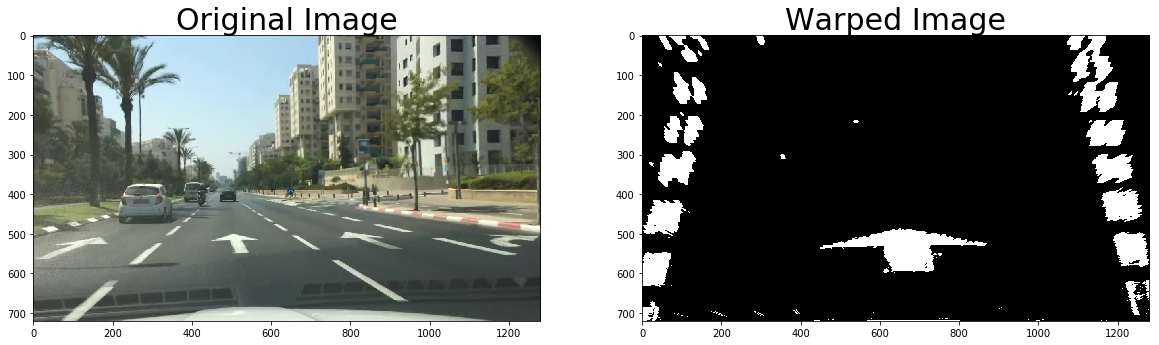

In [308]:
dst = pipeline(img)
dst = perspective_warp(dst, dst_size=(1280,720))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

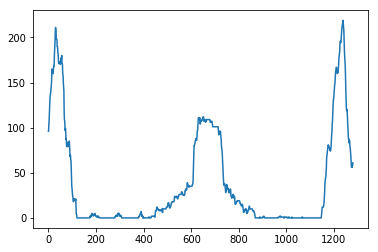

In [309]:
hist = np.sum(dst[dst.shape[0]//2:,:], axis=0) 
plt.plot(hist)

In [310]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]

def sliding_window(img, nwindows=9, margin=150, minpix = 1, draw_windows=True):
    global left_a, left_b, left_c, right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)
    out_img = np.dstack((img, img, img))*255

    histogram = get_hist(img)
    # find peaks of left and right halves
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows) # number of window for fitting curve
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin 
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if draw_windows == True:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_a.append(left_fit[0])
    left_b.append(left_fit[1])
    left_c.append(left_fit[2])
    
    right_a.append(right_fit[0])
    right_b.append(right_fit[1])
    right_c.append(right_fit[2])
    
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 100]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 100, 255]
    
    return out_img, (left_fitx, right_fitx), (left_fit_, right_fit_), ploty

def find_curve(img, leftx, rightx):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

def draw_lanes(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)
    
    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))]) #flip array in row
   
    cv2.polylines(color_img, np.int_(left), False, (255,0,0),40) # <- Use for marking on original image
    cv2.polylines(color_img, np.int_(right),False, (255,0,0),40) # <- Use for marking on original image
    
    inv_perspective = inv_perspective_warp(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 4, 3) #<- Use for marking on original image
    return inv_perspective

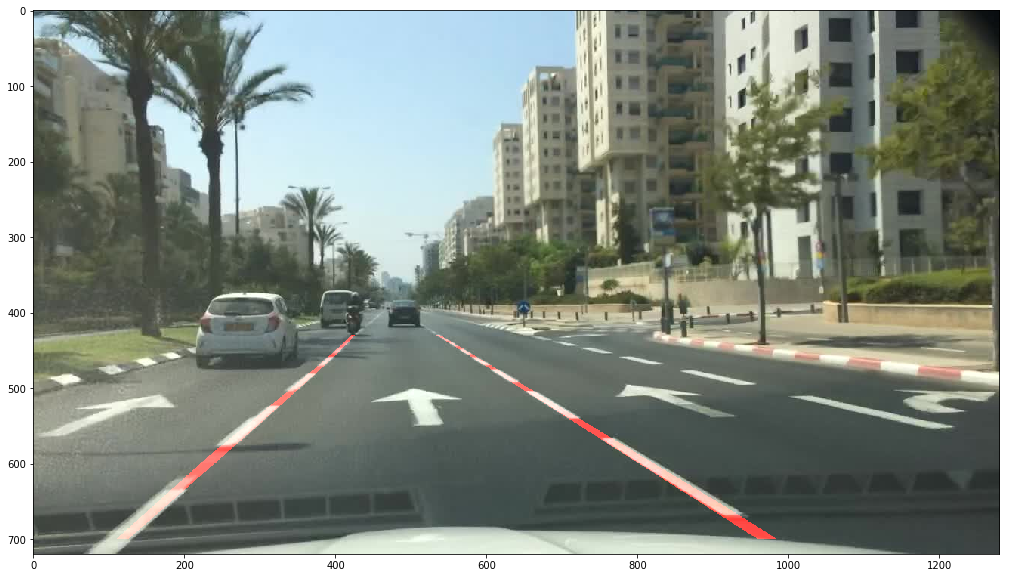

In [313]:
out_img, curves, lanes, ploty = sliding_window(dst)
curverad=find_curve(img, curves[0],curves[1])
plt.figure(figsize=(20,10))
imglines = draw_lanes(img, curves[0], curves[1])
plt.imshow(imglines)

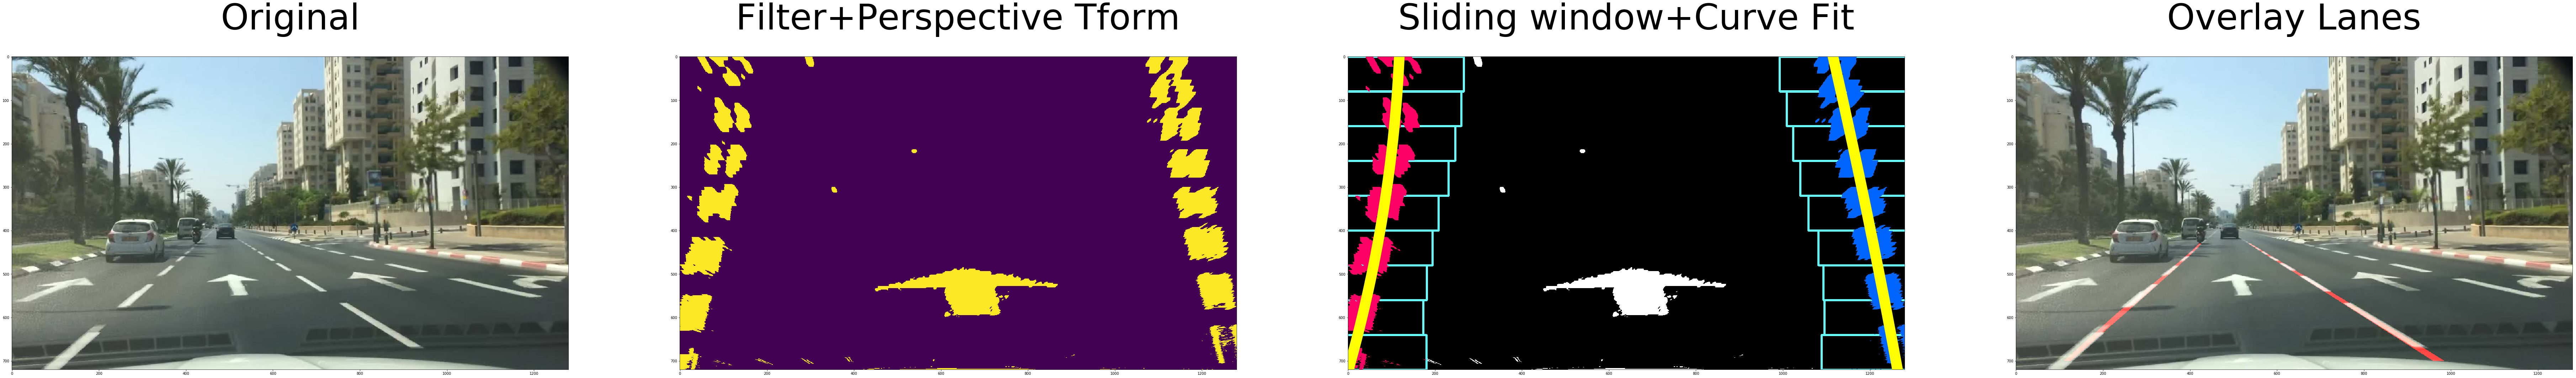

In [312]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(100, 20))
#f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=100, y=1.08)
ax2.imshow(dst)
ax2.set_title('Filter+Perspective Tform', fontsize=100, y=1.08)
ax3.imshow(out_img)
ax3.plot(curves[0], ploty, color='yellow', linewidth=30)
ax3.plot(curves[1], ploty, color='yellow', linewidth=30)
ax3.set_title('Sliding window+Curve Fit', fontsize=100, y=1.08)
ax4.imshow(img_)
ax4.set_title('Overlay Lanes', fontsize=100, y=1.08)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., wspace = 0.2)
